In [2]:
from pathlib import Path
from rdkit import Chem
from iotbx.data_manager import DataManager
import numpy as np
import sys
import tqdm
from multiprocessing import Pool
from contextlib import closing
sys.path.append("..")

from phenixml.fragments.fragments import MolContainer, Fragment
from phenixml.fragmentation.fragmenters import MoleculeFragmenter, BondFragmenter, AngleFragmenter
from phenixml.featurizers.fragments.fingerprints import MorganFeaturizer, RDKFingerprint
from phenixml.labelers.fragment_labelers import BondFragmentLabeler, AngleFragmentLabeler
from phenixml.featurizers.fragments.ani_featurizer import ANIFeaturizer

from phenixml.models.nn_fragments import FragmentKNN
from phenixml.visualization.fragment_display import FragmentDisplay
display = FragmentDisplay()

from phenixml.visualization.plotting import plot_geom_eval
from phenixml.utils.torch_utils import to_np
import matplotlib.pyplot as plt

In [3]:
#get molecules
mol_dir = "/dev/shm/cschlick/geostd_passed/"
containers = MolContainer.from_folder(mol_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16151/16151 [00:33<00:00, 482.63it/s]


In [4]:
%%time
# Fragment and featurize using multiprocessing

# define worker function
def worker(container):
  fragmenter = AngleFragmenter(exclude_elements=["H"])
  fragments = fragmenter(container)
  try:
    features = ANIFeaturizer.from_fragments_midpoint(fragments)
    return (fragments,features)
  except:
    return None

# Run
work = containers
results = []
with closing(Pool(processes=64)) as pool:
  for result in tqdm.tqdm(pool.imap_unordered(worker, work), total=len(work)):
      results.append(result)
  pool.terminate()


# Collate results
fragments = []
features = []
for result in results:
  if result is not None:
    fragments+= result[0]
    features.append(result[1])
features = np.vstack(features)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16150/16150 [01:07<00:00, 238.12it/s]


CPU times: user 1min 1s, sys: 19.1 s, total: 1min 21s
Wall time: 1min 12s


In [5]:
%%time
# label the fragments
labeler = AngleFragmentLabeler()
labels = labeler(fragments)

CPU times: user 23.6 s, sys: 142 ms, total: 23.8 s
Wall time: 23.8 s


In [6]:
# train/test split
from sklearn.model_selection import train_test_split
inds = np.arange(len(fragments))
train,test = train_test_split(inds,test_size=0.2)
feat_train, feat_test = features[train], features[test]
labels_train, labels_test = labels[train], labels[test]
frags_train = [fragments[i] for i in train]
frags_test = [fragments[i] for i in test]

## kNN

In [8]:
%%time
# Build the pynndescent index
knn = FragmentKNN(frags_train,feat_train)

CPU times: user 1h 11min 54s, sys: 3min 39s, total: 1h 15min 34s
Wall time: 4min 35s


In [9]:
# choose a single query to illustrate kNN search
query_idx = 100
query_frag = frags_test[query_idx]
query_feature = feat_test[query_idx]
query_label = labels_test[query_idx]

nbrs,inds = knn.query(query_feature,k=20, return_ind=True)
nbr_labels = labels_train[inds]

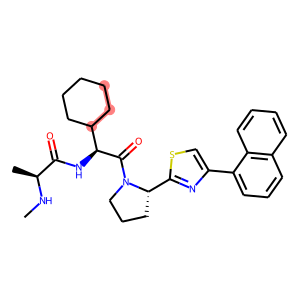

In [11]:
display(query_frag,hideHs=True,size=(300,300))

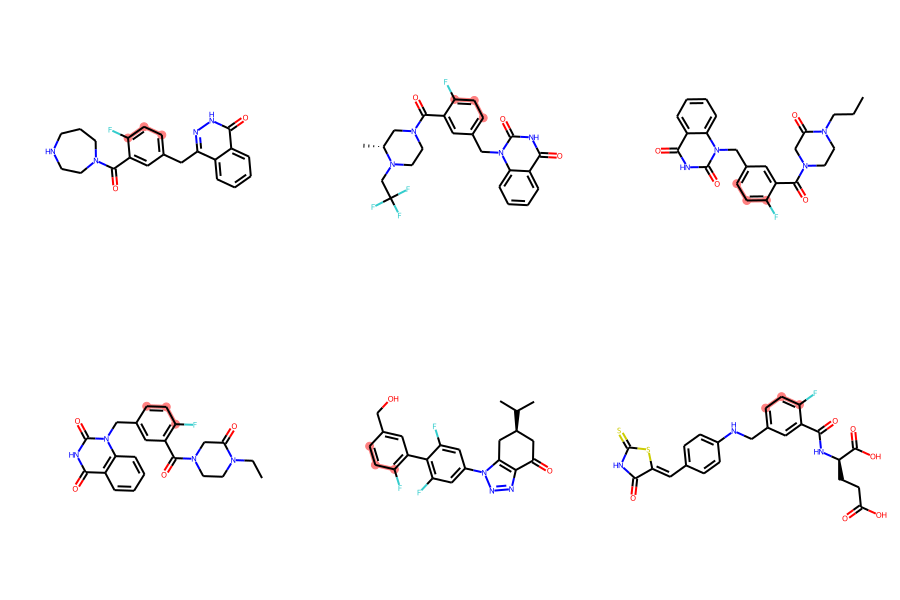

In [9]:
display(nbrs)

In [10]:
# kNN Regression
# Query the knn for the whole test set
nbrs,inds = knn.query(feat_test,k=20, return_ind=True)
nbr_labels = labels_train[inds]

In [11]:
nbr_mean_label = nbr_labels.mean(axis=1)[:,0]

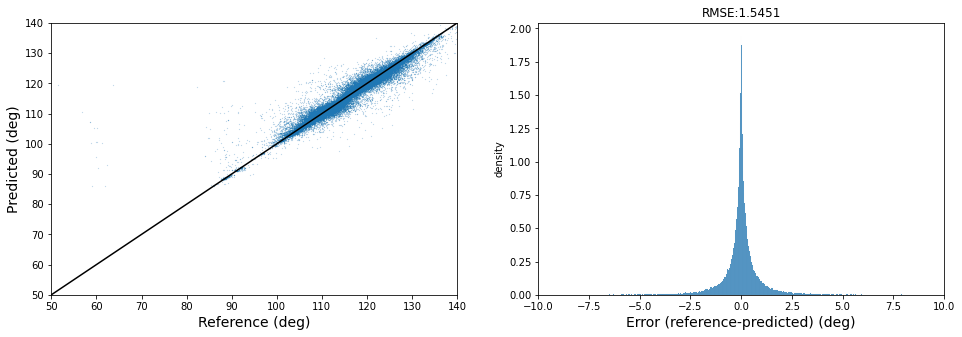

In [13]:
plot_geom_eval(np.degrees(labels_test),np.degrees(nbr_mean_label),mode="angle")

In [15]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15815
Mols better than cutoff: 15604
Mols worse than cutoff: 211


## MLP Regression

In [16]:
import torch
from phenixml.models.feature_regression import FeatureModel

In [17]:
model = FeatureModel(feat_train.shape[1],256,1,n_hid_layers=1)
opt = torch.optim.Adam(model.parameters(),lr=1e-4)
metric = torch.nn.MSELoss()

In [18]:
# set up tensors
gpuid = 1
feat_train_t = torch.tensor(feat_train,dtype=torch.get_default_dtype())
feat_test_t = torch.tensor(feat_test,dtype=torch.get_default_dtype())
labels_train_t = torch.tensor(labels_train,dtype=torch.get_default_dtype())

if gpuid is not None:
  feat_train_t = feat_train_t.to("cuda:"+str(gpuid))
  labels_train_t = labels_train_t.to("cuda:"+str(gpuid))
  model = model.to("cuda:"+str(gpuid))

In [19]:
# train
epoch_losses = []
n_epoch=3000


for epoch in tqdm.tqdm(range(n_epoch)):
    
  pred = model(feat_train_t)
  loss = metric(pred,labels_train_t)
  opt.zero_grad()
  loss.backward()
  opt.step()
  
  epoch_losses.append(loss.item())
  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:28<00:00, 11.16it/s]


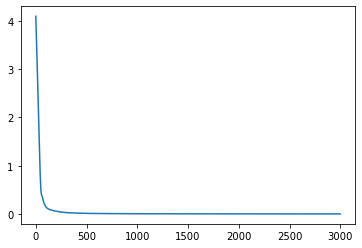

In [20]:
plt.plot(epoch_losses)

In [21]:
if gpuid is not None:
  model = model.to("cpu")
pred = model(feat_test_t)

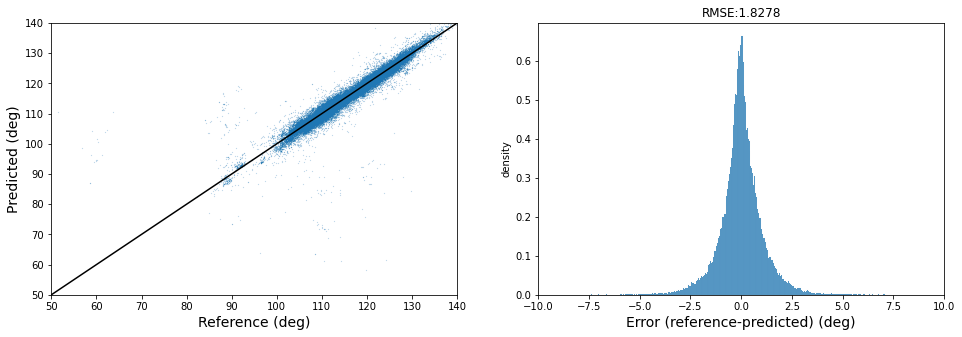

In [22]:
plot_geom_eval(np.degrees(labels_test),np.degrees(to_np(pred)),mode="angle")

In [23]:
# evaluate
from collections import defaultdict
mol_containers = defaultdict(list)

labels_test_ref = np.degrees(labels_test)
labels_test_pred = np.degrees(nbr_mean_label)

for i,fragment in enumerate(frags_test):
  
  ref,pred = labels_test_ref[i], labels_test_pred[i]
  error = np.abs(ref-pred)
  mol_containers[fragment.mol_container].append(error)
  
worst = np.array([np.max(value) for key,value in mol_containers.items()])
cutoff = 10
n_ok = (worst<=cutoff).sum()
n_bad = (worst>cutoff).sum()
print("Number of mols in test set:",len(mol_containers))
print("Mols better than cutoff:",n_ok)
print("Mols worse than cutoff:",n_bad)

Number of mols in test set: 15815
Mols better than cutoff: 15604
Mols worse than cutoff: 211
